<a href="https://colab.research.google.com/github/NJ-Sleep/Machine-Learning-practice/blob/main/NJ_Alexnet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTING THE LIBRARIES
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

#(NERI) LIBRARIES USED TO GRAPH
import os
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# THIS TO RUN THE DATASET

def get_train_valid_loader(data_dir,
                               batch_size,
                               augment,
                               random_seed,
                               valid_size=0.1,
                               shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        valid_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
        ])
        if augment:
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop(227), # Changed from RandomCrop to RandomResizedCrop to ensure 227x227 output
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
            ])

        # (NERI) Load the dataset using ImageFolder
        train_data_src = '/content/drive/MyDrive/DogskinDiseaseCSV/PWD_CSV/train'
        valid_data_src = '/content/drive/MyDrive/DogskinDiseaseCSV/PWD_CSV/valid'

        train_dataset = datasets.ImageFolder(root=train_data_src, transform=train_transform)
        valid_dataset = datasets.ImageFolder(root=valid_data_src, transform=valid_transform)


        # (NERI) I didnt make this next part
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=shuffle) # Use shuffle directly in DataLoader

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle validation data

        return (train_loader, valid_loader)


def get_test_loader(data_dir,
                        batch_size,
                        shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )

        # define transform
        transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])
        # (NERI) Load Test Dataset
        test_data_src = '/content/drive/MyDrive/DogskinDiseaseCSV/PWD_CSV/test'
        test_dataset = datasets.ImageFolder(root=test_data_src, transform=transform)


        # (NERI) I didnt make this next part
        data_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

# Load the datasets
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',batch_size = 64,augment = False,random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                                  batch_size = 64)

In [3]:
# THE CNN MODEL ITSELF
class AlexNet(nn.Module):
        def __init__(self, num_classes=10):
            super(AlexNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer5 = nn.Sequential(
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(9216, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out

In [4]:
# SETTING THE HYPERPARAMETERS
num_classes = 11
num_epochs = 180
batch_size = 250
learning_rate = 0.005

# (NERI) TO GRAPH THE LOSSES AND CORRECT OUTPUT OF THE CNN
train_losses = []
test_losses = []
train_correct = []
test_correct = []

model = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

# Train the model
total_step = len(train_loader)

In [5]:
# TRAINING THE CNN
total_step = len(train_loader)

for epoch in range(num_epochs):
    trn_corr = 0
    tst_corr = 0
    for i, (images, labels) in enumerate(train_loader):
        i += 1
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # (NERI) USED TO GET THE LOSS OF EPOCH
        predicted = torch.max(outputs.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # (NERI) To see which batch the currently
        if i % 250 == 0:
          print(f'Epoch: {epoch} Batch: {i} Loss: {loss.item()}')

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

      # (NERI) TO TRACK THE LOSS AND CORRECT OF THE CNN
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/180], Step [57/56], Loss: 1.8651
Accuracy of the network on the 5000 validation images: 20.21276595744681 %
Epoch [2/180], Step [57/56], Loss: 1.6409
Accuracy of the network on the 5000 validation images: 19.78723404255319 %
Epoch [3/180], Step [57/56], Loss: 1.1927
Accuracy of the network on the 5000 validation images: 22.340425531914892 %
Epoch [4/180], Step [57/56], Loss: 1.2608
Accuracy of the network on the 5000 validation images: 22.76595744680851 %
Epoch [5/180], Step [57/56], Loss: 1.1562
Accuracy of the network on the 5000 validation images: 22.5531914893617 %
Epoch [6/180], Step [57/56], Loss: 1.2070
Accuracy of the network on the 5000 validation images: 26.914893617021278 %
Epoch [7/180], Step [57/56], Loss: 0.9316
Accuracy of the network on the 5000 validation images: 24.25531914893617 %
Epoch [8/180], Step [57/56], Loss: 0.8501
Accuracy of the network on the 5000 validation images: 30.21276595744681 %
Epoch [9/180], Step [57/56], Loss: 1.5489
Accuracy of the netwo

In [32]:
#TESTING THE CNN
with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            test_losses.append(loss)
            test_correct.append(correct)

            del images, labels, outputs


        print('Accuracy of the network on the {} test images: {} %'.format(5000, 100 * correct / total))

        # (NERI) USED TO GRAPH LOSS OF EPOCHS


Accuracy of the network on the 5000 test images: 74.09420289855072 %


Text(0, 0.5, 'Loss')

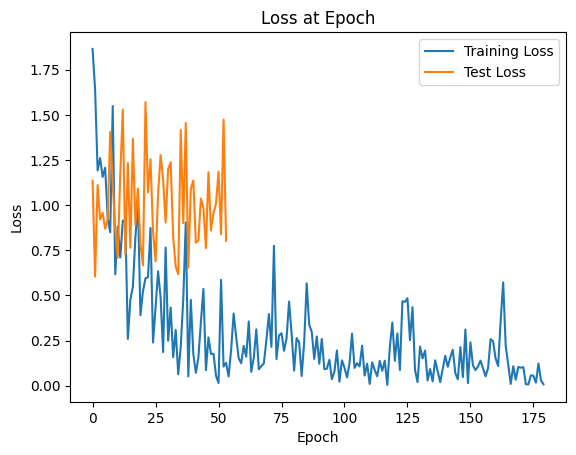

In [33]:
# GRAPH THE LOSS AT EPOCHS
# Ensure train_losses are on CPU and converted to numbers (already done in the training loop fix)
# Ensure test_losses are on CPU and converted to numbers
# Convert test_losses tensors to CPU and then to a list of numbers
test_loss = [loss.item() for loss in test_losses]


plt.plot(train_losses, label='Training Loss')
plt.plot(test_loss, label='Test Loss') # Use the CPU version for plotting
plt.title('Loss at Epoch')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")



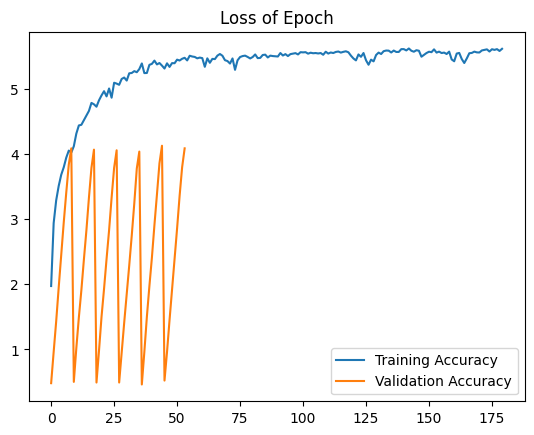

In [34]:
# Convert tensors to CPU and then to a list of numbers for plotting
train_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in train_correct]
test_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in test_correct]

plt.plot([t/600 for t in train_correct_cpu], label='Training Accuracy') # Use the CPU version for plotting
plt.plot([t/100 for t in test_correct_cpu], label = 'Validation Accuracy') # Use the CPU version for plotting
plt.title('Loss of Epoch')
plt.legend()
plt.show() # Added to display the plot